<img src="Imagenes/preparacion_datasett.jpg" alt="Imagen creada con inteligencia artificial y editada con Microsoft Paint" style="border-radius: 15px">


*Imagen creada con inteligencia artificial.*


## **INTRODUCCIÓN** 

Como se ha visto en el EDA de data set no todas las etiquetas, es decir las emociones, estan igualmente representadas, por ejemplo la etiqueta 3 (Felicidad) tiene 8989 entradas mientras que la etiqtea 1 (Asco) tiene tan solo 547 entradas. 

Pese a que 547 podria parecer "no pocas" entradas este desbalanceo puede suponer una merma importante en la calidad de un modelo. 
Lo ideal sería aumentar el dataset con mas fotografias, pero esto es tedioso, lleva tiempo y no es lo más practico. 

La opcion que aqui se muestra es crear fotografias nuevas a partir de las ya existentes, volteandolas horizontalmente, añadiendo algo de ruido y aumento o disminuyendo el brillo 
de esta forma, y haciendocelo solo a las clases/emociones mas subrepresentadas podemos conseguir un nuevo dataset algo mas balanceado. 

> Este notebook puede parecer algo complicado, al final hay un resumen explicacion.
>>Durante todo el nootebook hay explicaciones.  
>    
>Si, efectivamente, la imagen del banner es un guiño al hecho que aquí se arreglan fotos.    
>Si despues del modelado este sigue sin dar bueno resultados, se aumentará el numero de pasos en este nootebook.

## **BIBLIOTECAS USADAS:**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import ast  

## **CARGA DEL DASET**

In [2]:
df = pd.read_csv('./datos/fer2013/fer2013.csv')

## **FLIP HORIZONTAL**

> Las etiquetas 1, 5 y 0 son las más subrepresentadas, por lo que prepararemos un dataframe solo con estas etiquetas y le haremos flip horizontal.  
>
>La etiqueta 0 esta mucho mas representada que la 1, por lo que de 1 solo tomaremos la mitad.


In [3]:
df_filtered_1_5 = df[df['emotion'].isin([1, 5])]
df_filtered_0 = df[df['emotion'] == 0]
random_indices = np.random.choice(df_filtered_0.index, size=len(df_filtered_0) // 2, replace=False)
df_filtered_0_half = df.loc[random_indices]
df_espejo = pd.concat([df_filtered_1_5, df_filtered_0_half]) 
df_sin_espejo = df[df['emotion'].isin([1, 0, 5])] #esto es solo para ver si ha funcionado o no.

In [4]:
def flip_image_horizontal(pixel_string):
    try:
        pixel_values = list(map(int, pixel_string.split()))
        size = int(np.sqrt(len(pixel_values)))
        image_matrix = np.array(pixel_values).reshape((size, size))
        flipped_image_matrix = np.fliplr(image_matrix)
        flipped_pixel_string = ' '.join(map(str, flipped_image_matrix.flatten()))
        return flipped_pixel_string
    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return pixel_string  # Devuelve la cadena original en caso de error
df_espejo.loc[:, 'pixels'] = df_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))


Visualizamos primero sin voltear y luego volteado, para ver si se ha realizado correctamente.

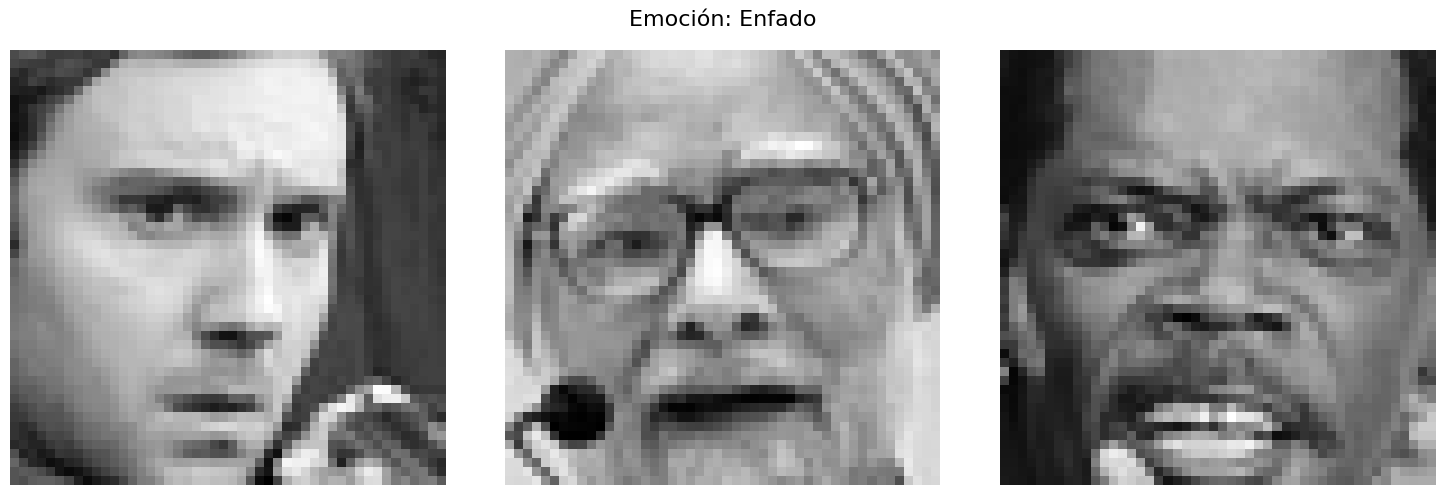

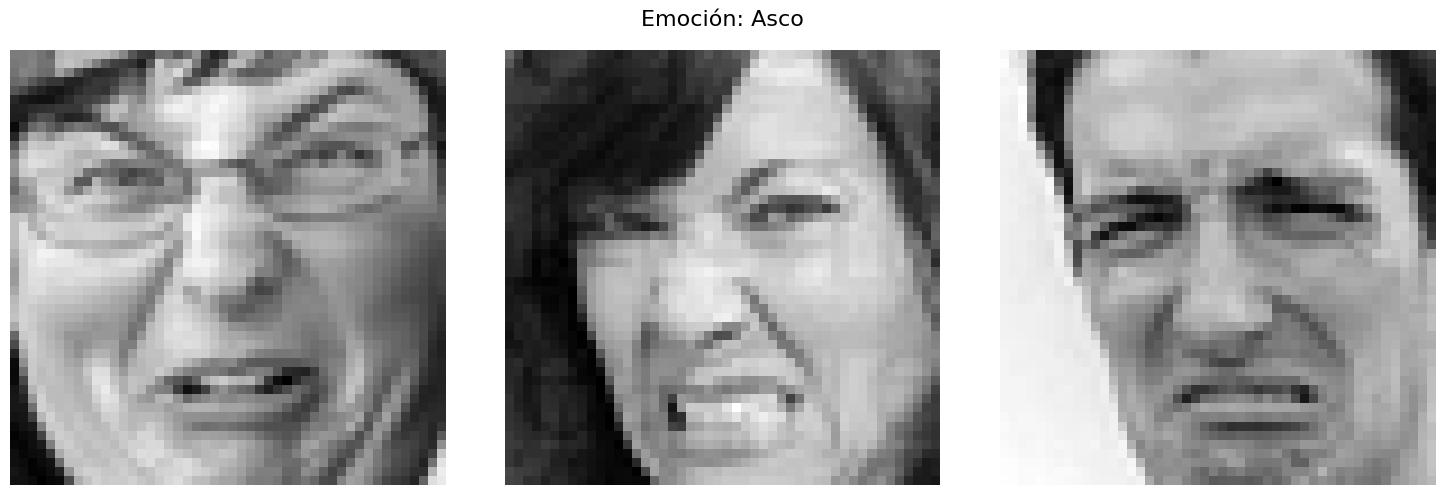

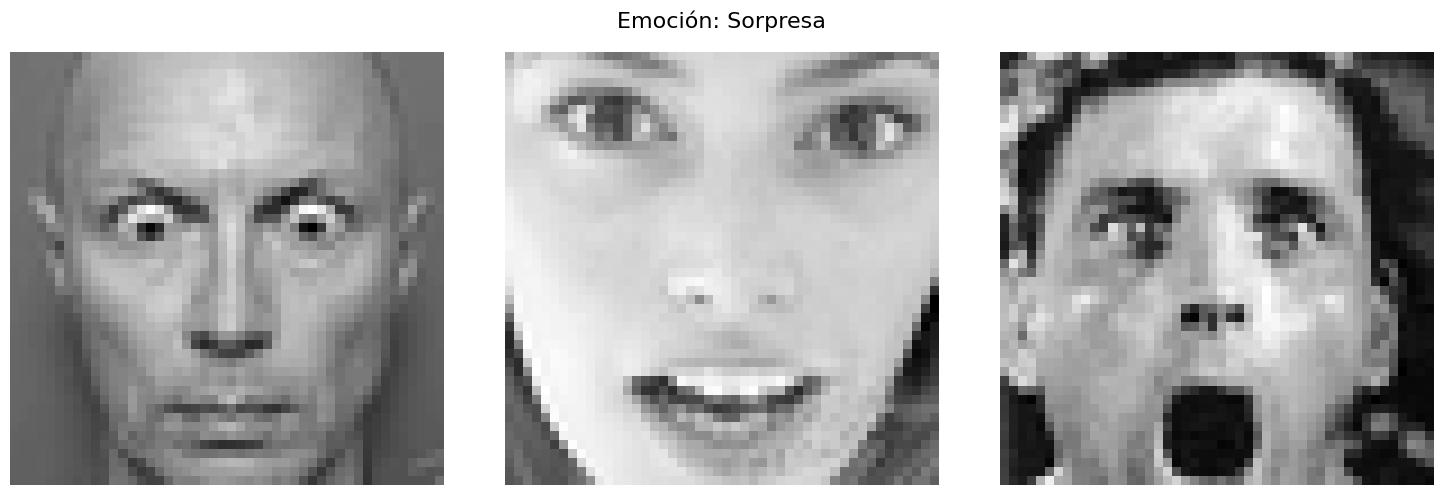

In [5]:
emotion_labels = {0: 'Enfado', 1: 'Asco', 5: 'Sorpresa'}
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()

for emotion in [0, 1, 5]:
    mostrar_imagenes_emocion(df_sin_espejo, emotion)


Ahora vemos el volteado.

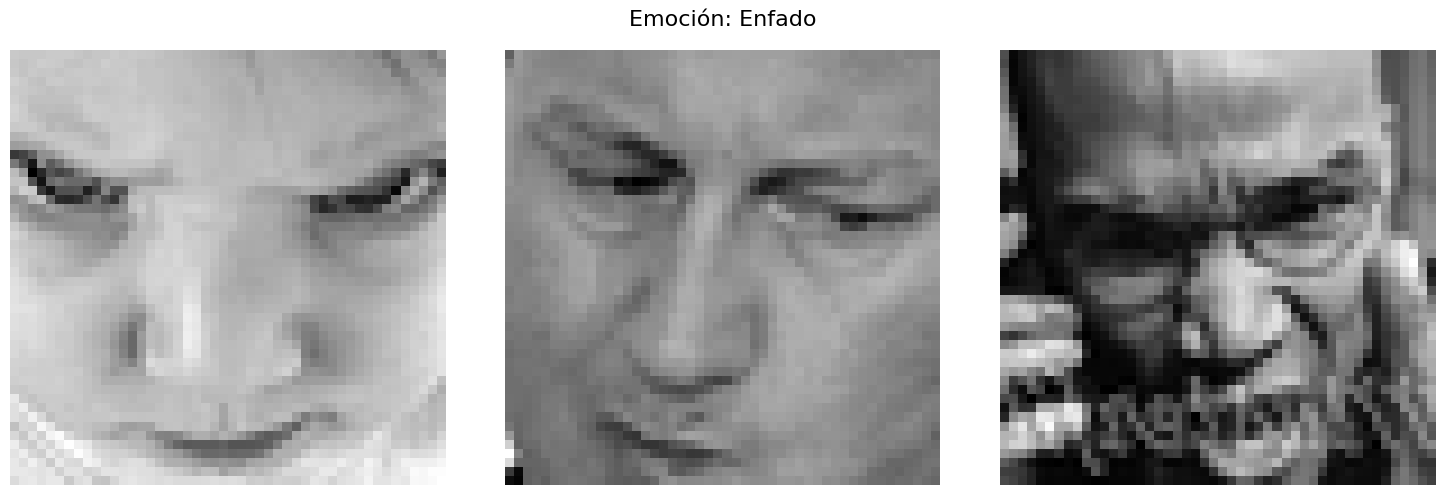

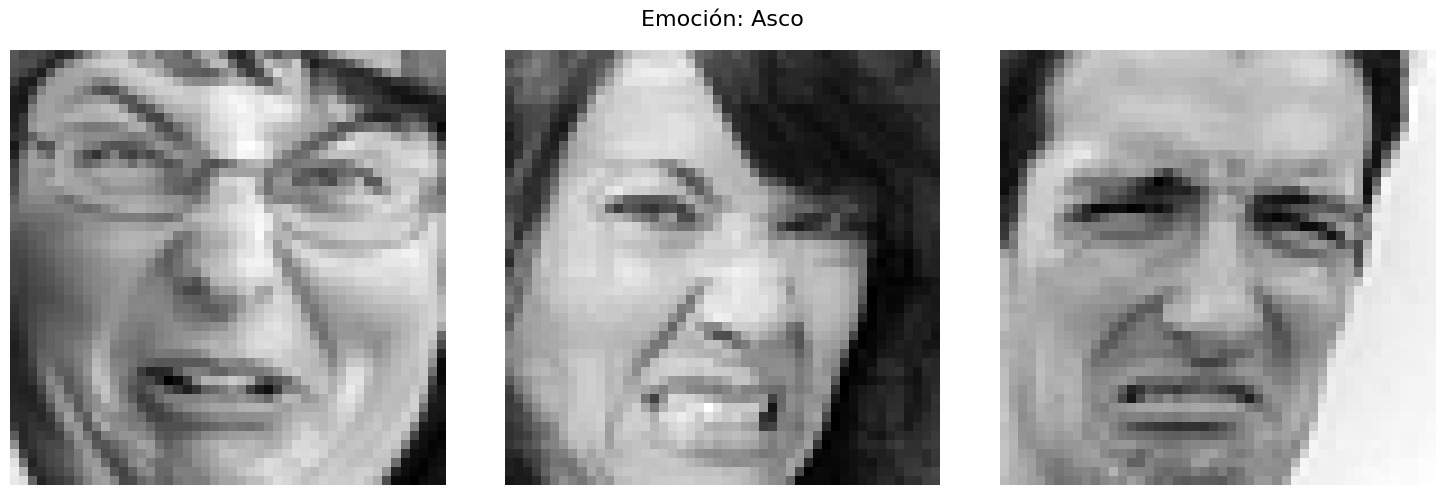

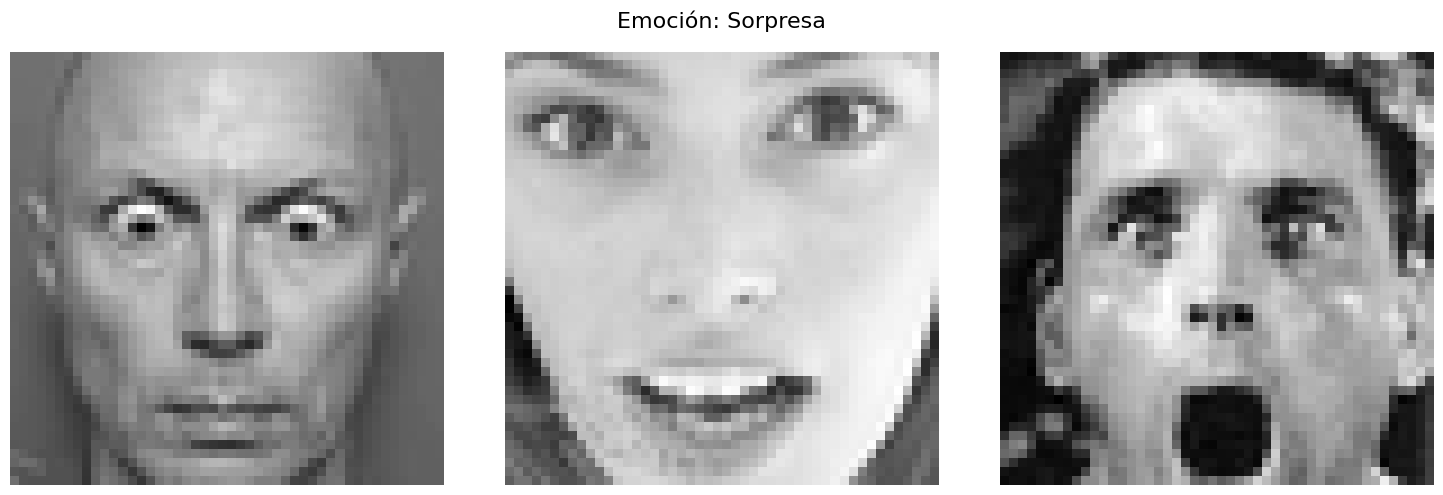

In [6]:
for emotion in [0, 1, 5]:
    mostrar_imagenes_emocion(df_espejo, emotion)


El volteo horizontal ha sido todo un éxito, podemos unir los dataframes.

In [7]:
#df_espejo['emotion'].value_counts() # con esto comprobamos que las fotos se han volteado pero no mantiene las originales, lo comentamos para que no se haga muy largo. 
df_con_volteo = pd.concat([df, df_espejo], ignore_index=True)

Comprobemos si ha ido bien la cosa:

In [8]:
print("Antes de añadir las fotos volteadas horizontalmente:")
print(df['emotion'].value_counts())
print()
print("Despues de añadir las fotos:")
print(df_con_volteo['emotion'].value_counts())

Antes de añadir las fotos volteadas horizontalmente:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

Despues de añadir las fotos:
emotion
3    8989
5    8004
0    7429
6    6198
4    6077
2    5121
1    1094
Name: count, dtype: int64


## **AÑADIDO DE RUIDO"**  

Se lo haremos primero solo a la emoción 1, a todas las entradas. 

In [9]:
df_ruido_01 = df_con_volteo[df_con_volteo['emotion'] == 1] 
df_sin_ruido_01 = df_con_volteo[df_con_volteo['emotion'] == 1] 

In [13]:
def add_gaussian_noise(image_str, var=0.1):
    image_list = list(map(int, image_str.split()))
    size = int(len(image_list) ** 0.5)  
    image_array = np.array(image_list).reshape((size, size))
    mean = 0
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (size, size))
    noisy = np.clip(image_array + gauss * 70, 0, 255).astype(np.uint8)
    noisy_list = noisy.flatten().tolist()
    return ' '.join(map(str, noisy_list))  
df_ruido_01.loc[:, 'pixels'] = df_ruido_01['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.01))






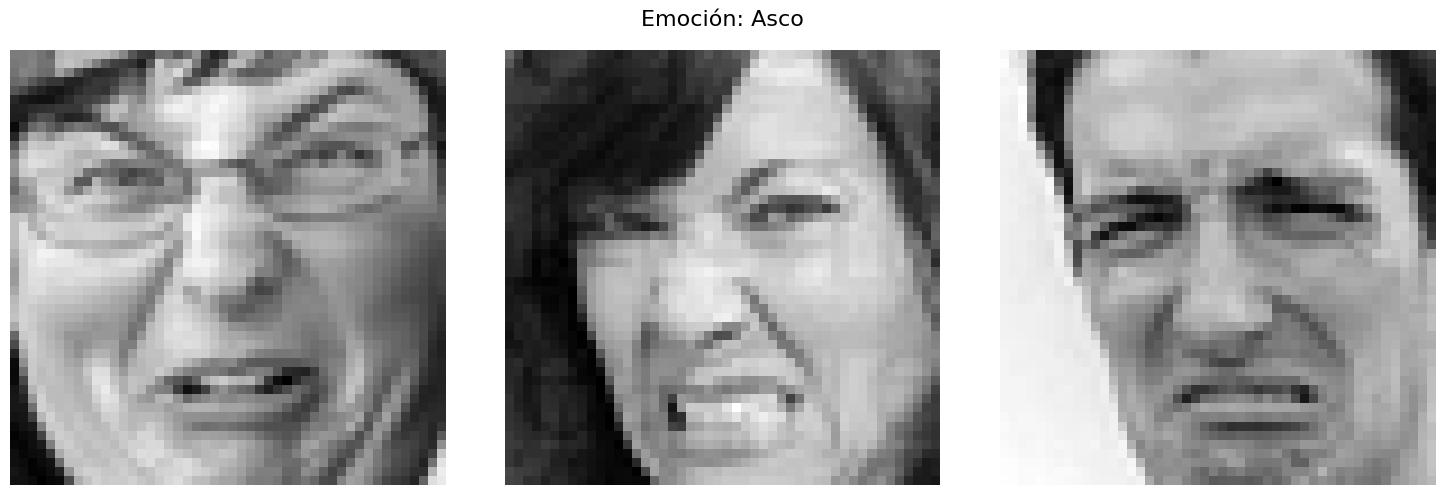

In [11]:
emotion_labels = {1: 'Asco'}
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()

for emotion in [1]:
    mostrar_imagenes_emocion(df_sin_ruido_01, emotion)

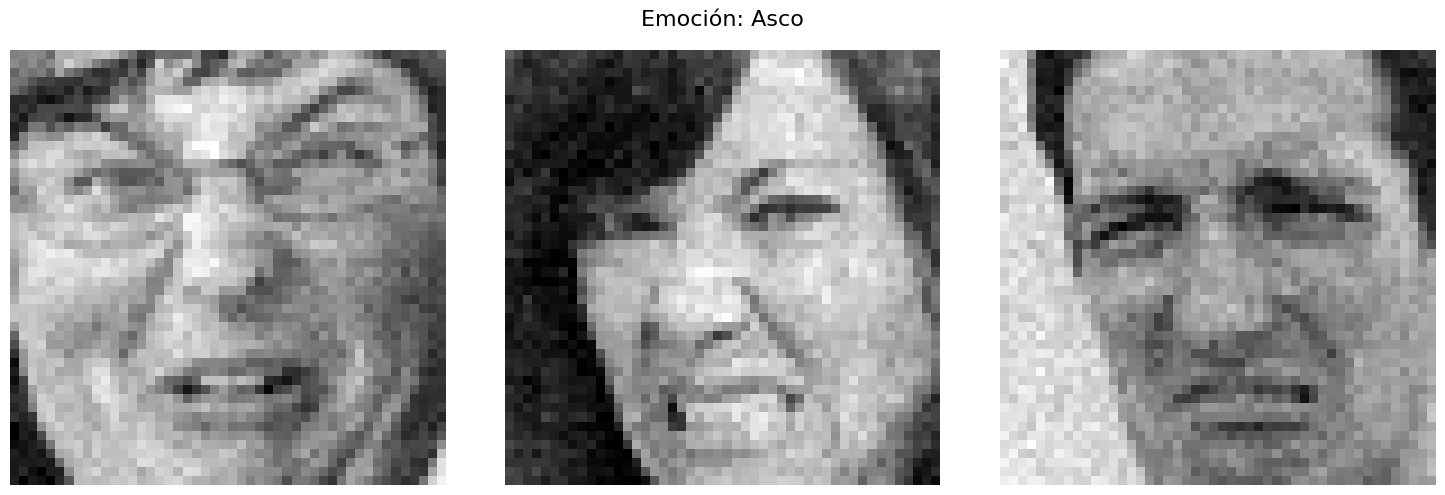

In [14]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_ruido_01, emotion)

In [17]:
df_con_volteo_ruido_01 = pd.concat([df_con_volteo, df_ruido_01], ignore_index=True) 
df_con_volteo_ruido_01.to_csv('./datos/fer2013/fer2013_aumentado.csv', index=False)

# Aumentación de Datos en fer2013 Dataset

Este notebook aborda el desbalance de clases en el conjunto de datos fer2013 mediante técnicas de aumentación de datos.  
El objetivo es mejorar la representación de emociones subrepresentadas como "Enfado", "Asco" y "Sorpresa".

## Objetivo

El desbalance de clases afecta la capacidad de los modelos de aprendizaje automático para generalizar correctamente.  
Se emplea la aumentación de datos para equilibrar la distribución de emociones y mejorar el rendimiento del modelo.

## Pasos Realizados

1. **Carga y Filtrado del Dataset:** Se filtran las emociones subrepresentadas, 1, 5 y la mitad de 5, del conjunto de datos fer2013.

2. **Volteo Horizontal de Imágenes:** Se implementa el volteo horizontal para duplicar las muestras de emociones subrepresentadas.

3. **Añadido de Ruido Gaussiano:** Se aplica ruido gaussiano a las imágenes de la emoción "Asco" para introducir variabilidad adicional.

4. **Verificación y Visualización:** Se verifican las transformaciones aplicadas visualmente para asegurar la calidad de las nuevas muestras generadas.

5. **Concatenación y Guardado:** Se concatenan los dataframes originales con las imágenes aumentadas y se guarda el nuevo dataframe en formato CSV.

## Resultados

Después de la aumentación de datos, se mejora significativamente la representación de emociones subrepresentadas. Esto puede llevar a modelos más equilibrados y robustos para el reconocimiento de emociones en imágenes.

En resumen, este notebook muestra cómo la aumentación de datos puede ser una estrategia efectiva para abordar el desbalance de clases en conjuntos de datos de imágenes como fer2013.
